In [82]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import Model
import pandas as pd
from sklearn import preprocessing
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

#### Load and prepare data

In [102]:
frame_file = 'paths.csv'
frame_text = 'path'
frame = pd.read_csv(frame_file)
#frame = frame[frame.most_frequent_percentage >= 0.6]

def build_source(label, df):
    df = df[df['class'] == label]
    return ColumnDataSource(data=dict(
    x=df.x.values.tolist(),
    y=df.y.values.tolist(),
    sentence=df.sentence.tolist(),
    path=df.path.tolist(),
    label=df['class'].tolist()))

In [103]:
vocab_size=5000
maxlen = 10
texts = frame[frame_text].values.tolist()
labels = frame.most_frequent_label.values.tolist()

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
input_train = tokenizer.texts_to_sequences(texts)

input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(['BETTER', 'WORSE', 'NONE'])
y_train =  to_categorical(label_encoder.transform(labels))
input_train = input_train.reshape((len(texts),maxlen,1))

In [104]:
input_train.shape

(3412, 10, 1)

#### Train the network

In [105]:
def get_desc():
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure(figsize=(7,7))
    plt.plot(history.history['acc'],color='green')
    plt.ylim(0,1)
    plt.plot(history.history['val_acc'],linestyle='--',color='yellowgreen')
    plt.plot(history.history['loss'],color='red')
    plt.plot(history.history['val_loss'],color='orangered',linestyle='--')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc', 'loss', 'val_loss'])
    plt.show()
    plt.figure(figsize=(20,10))

In [106]:
from keras.layers import Dense, LSTM, Dropout, Embedding,Flatten,Bidirectional, GlobalMaxPooling1D
from keras.models import Sequential
from keras import regularizers

model = Sequential()
model.add(LSTM(300,return_sequences=True,input_shape=(maxlen,1)))
model.add(LSTM(300,return_sequences=False))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
epochs=25, batch_size=64,shuffle=True, validation_split=0.2)

Train on 2729 samples, validate on 683 samples
Epoch 1/25
2729/2729 [==============================] - 5s 2ms/step - loss: 0.6694 - acc: 0.7556 - val_loss: 0.4943 - val_acc: 0.8594
Epoch 2/25
2729/2729 [==============================] - 2s 673us/step - loss: 0.5362 - acc: 0.8135 - val_loss: 0.4531 - val_acc: 0.8638
Epoch 3/25
2729/2729 [==============================] - 2s 699us/step - loss: 0.5363 - acc: 0.8142 - val_loss: 0.4517 - val_acc: 0.8507
Epoch 4/25
2729/2729 [==============================] - 2s 692us/step - loss: 0.5094 - acc: 0.8182 - val_loss: 0.4208 - val_acc: 0.8594
Epoch 5/25
2729/2729 [==============================] - 2s 664us/step - loss: 0.4934 - acc: 0.8186 - val_loss: 0.4119 - val_acc: 0.8594
Epoch 6/25
2729/2729 [==============================] - 2s 664us/step - loss: 0.4863 - acc: 0.8201 - val_loss: 0.4132 - val_acc: 0.8463
Epoch 7/25
2729/2729 [==============================] - 2s 674us/step - loss: 0.4861 - acc: 0.8219 - val_loss: 0.4052 - val_acc: 0.8521
Epo

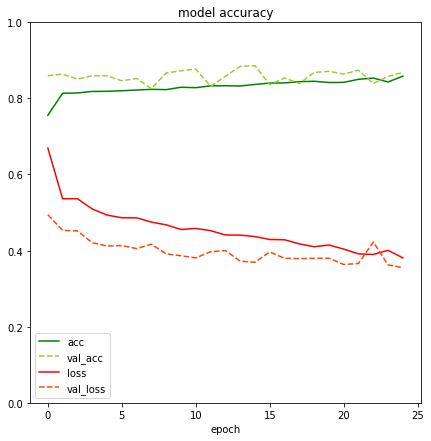

<Figure size 1440x720 with 0 Axes>

In [107]:
get_desc()

#### Prepare the embeddings

In [95]:
layer = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[layer].output)
intermediate_output = intermediate_layer_model.predict(input_train)
model.layers[layer]

In [96]:
e = intermediate_output
X = []
y = []
d = []

for i in range(len(frame)):
    X.append(e[i,:].reshape(-1,1).squeeze().tolist())
    d.append(e[i,:])
    y.append(frame.most_frequent_label.values.tolist()[i])

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,verbose=1).fit_transform(d)
ddf = pd.DataFrame(columns=['x','y','class','sentence', 'path'])
for i,x in enumerate(X_embedded):
    ddf.loc[i] = [x[0],x[1],frame.most_frequent_label.values.tolist()[i],frame.sentence.values.tolist()[i],frame.path.values.tolist()[i]]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3412 samples in 0.046s...
[t-SNE] Computed neighbors for 3412 samples in 3.355s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3412
[t-SNE] Computed conditional probabilities for sample 2000 / 3412
[t-SNE] Computed conditional probabilities for sample 3000 / 3412
[t-SNE] Computed conditional probabilities for sample 3412 / 3412
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.496948


### Plot

In [98]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

figure(x_axis_type = "datetime",    
  tools="pan,wheel_zoom,box_zoom,reset,previewsave",plot_width=1000, 
  name="myplot")

colormap = {'WORSE': 'red', 'BETTER': 'green', 'NONE': 'blue'}
colors = [colormap[x] for x in ddf['class']]


hover = HoverTool(tooltips=[
    ("Sentence", "@sentence"),
    ("Path", "@path"),
    ("label", "@label"),
])

p = figure(plot_width=900,  plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,previewsave")
p.add_tools(hover)

p.cross(x='x', y='y', source=build_source('NONE', ddf),size=5,color='gray')
p.circle(x='x', y='y', source=build_source('WORSE', ddf) ,size=5,color='red')
p.circle(x='x', y='y', source=build_source('BETTER', ddf),size=5,color='green')


show(p)

### Classification Test

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
kf = StratifiedKFold(n_splits=2, random_state=1337)
for train_index, test_index in kf.split(X,y):
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    log = LogisticRegression()
    log.fit(X_train, y_train)
    pred = log.predict(X_test)
    print(classification_report(pred,y_test,labels=['BETTER', 'WORSE', 'NONE']))

             precision    recall  f1-score   support

     BETTER       0.63      0.71      0.67       279
      WORSE       0.22      0.50      0.31        46
       NONE       0.97      0.90      0.93      1382

avg / total       0.89      0.86      0.87      1707

             precision    recall  f1-score   support

     BETTER       0.68      0.65      0.66       329
      WORSE       0.14      0.52      0.22        27
       NONE       0.94      0.90      0.92      1349

avg / total       0.88      0.85      0.86      1705

